# Visual-language assistant with nanoLLaVA and OpenVINO

nanoLLaVA is a "small but mighty" 1B vision-language model designed to run efficiently on edge devices. It uses [SigLIP-400m](https://huggingface.co/google/siglip-so400m-patch14-384) as Image Encoder and [Qwen1.5-0.5B](https://huggingface.co/Qwen/Qwen1.5-0.5B) as LLM.
In this tutorial, we consider how to convert and run nanoLLaVA model using OpenVINO. Additionally, we will optimize model  using [NNCF](https://github.com/openvinotoolkit/nncf)

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Load PyTorch model](#Load-PyTorch-model)
- [Run PyTorch Model Inference](#Run-PyTorch-Model-Inference)
- [Convert and Optimize model](#Convert-and-Optimize-model)
    - [Convert model to OpenVINO IR format](#Convert-model-to-OpenVINO-IR-format)
    - [Compress Model weights to 4 and 8 bits using NNCF](#Compress-Model-weights-to-4-and-8-bits-using-NNCF)
    - [Image Encoder](#Image-Encoder)
    - [Text Embeddings](#Text-Embeddings)
    - [Language Model](#Language-Model)
- [Prepare model inference pipeline](#Prepare-model-inference-pipeline)
- [Run OpenVINO Model Inference](#Run-OpenVINO-Model-Inference)
    - [Select device](#Select-device)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/nano-llava-multimodal-chatbot/nano-llava-multimodal-chatbot.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%pip install -q "torch>=2.1" "transformers>=4.40" "accelerate" "pillow" "gradio>=4.26" "openvino>=2024.1.0" "tqdm" "nncf>=2.10" --extra-index-url https://download.pytorch.org/whl/cpu

In [2]:
from huggingface_hub import snapshot_download
from pathlib import Path

model_local_dir = Path("nanoLLaVA")

if not model_local_dir.exists():
    snapshot_download(repo_id="qnguyen3/nanoLLaVA", local_dir=model_local_dir)

modeling_file = model_local_dir / "modeling_llava_qwen2.py"
orig_modeling_file = model_local_dir / f"orig_{modeling_file.name}"


# model code depends from flash_attn package that may be problematic to load. Patch model code for avoiding import of this package
if not orig_modeling_file.exists():
    modeling_file.rename(orig_modeling_file)
with orig_modeling_file.open("r") as f:
    content = f.read()
replacement_lines = [
    ("from flash_attn import flash_attn_func, flash_attn_varlen_func", ""),
    ("from flash_attn.bert_padding import index_first_axis, pad_input, unpad_input", ""),
    (' _flash_supports_window_size = "window_size" in list(inspect.signature(flash_attn_func).parameters)', "pass"),
]

for replace_pair in replacement_lines:
    content = content.replace(*replace_pair)

with modeling_file.open("w") as f:
    f.write(content)

## Load PyTorch model
[back to top ⬆️](#Table-of-contents:)


For creating PyTorch model we should use `from_pretrained` method of `AutoModelForCausalLM` model class. Model weights are already downloaded from HuggingFace hub using `snapshot_download` function on previous step.

In [ ]:
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image
import warnings

transformers.logging.set_verbosity_error()
warnings.filterwarnings("ignore")

model = AutoModelForCausalLM.from_pretrained(model_local_dir, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_local_dir, trust_remote_code=True)

## Run PyTorch Model Inference
[back to top ⬆️](#Table-of-contents:)

Describe this image in detail


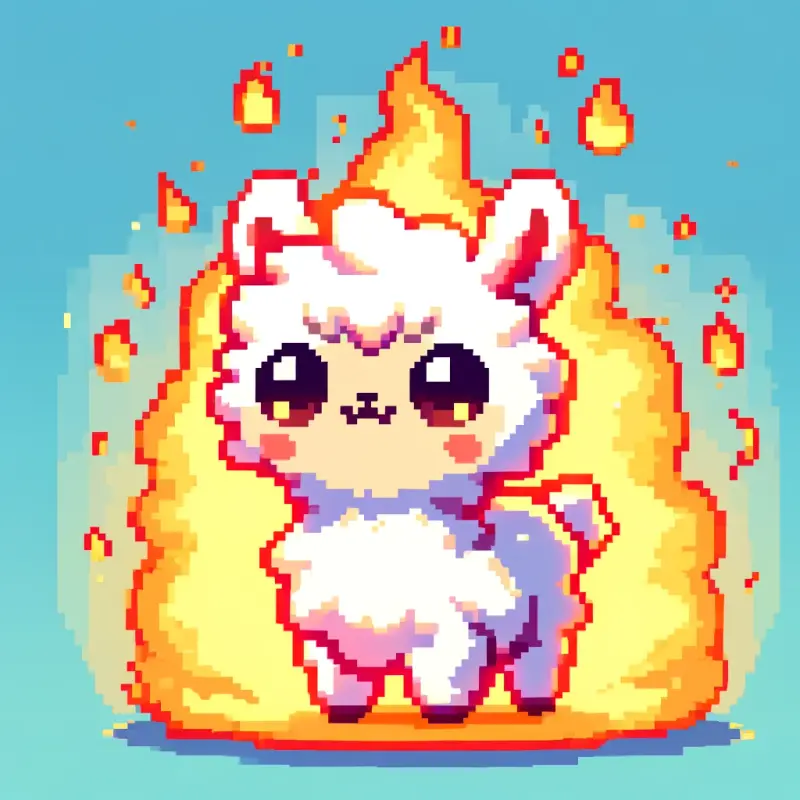

In [4]:
import torch
import requests

prompt = "Describe this image in detail"

messages = [{"role": "user", "content": f"<image>\n{prompt}"}]
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

text_chunks = [tokenizer(chunk).input_ids for chunk in text.split("<image>")]
input_ids = torch.tensor(text_chunks[0] + [-200] + text_chunks[1], dtype=torch.long).unsqueeze(0)
url = "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/8bf7d9f2-018a-4498-bec4-55f17c273ecc"
image = Image.open(requests.get(url, stream=True).raw)
image_tensor = model.process_images([image], model.config)
print(prompt)
image

In [5]:
from transformers import TextStreamer

streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

output_ids = model.generate(input_ids, images=image_tensor, max_new_tokens=128, use_cache=True, streamer=streamer)

The image depicts a charming, white, fluffy llama standing in a fire. The llama is surrounded by a warm, orange glow that creates a vibrant and lively atmosphere. The llama is captured in the middle of a fire, with its body and tail visibly engulfed in flames. The fire appears to be quite intense, as it is being fueled by a source of fire, creating a striking contrast between the bright fire and the white llama.
The llama's face is expressive, with its small, brown eyes sparkling with curiosity and excitement. Its nose is a bright pink, adding to the overall appeal of the llama. The llama's ears are also


## Convert and Optimize model
[back to top ⬆️](#Table-of-contents:)


Our model conversion and optimization consist of following steps:
1. Convert model to OpenVINO format and save it on disk.
2. Compress model weights using NNCF

Let's consider each step more deeply.

#### Convert model to OpenVINO IR format
[back to top ⬆️](#Table-of-contents:)

Convert model to OpenVINO format using conversion helper function defined bellow. We will use [OpenVINO Model Conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html) for conversion PyTorch model to OpenVINO Intermediate Representation format. `ov.convert_model` function accepts PyTorch model instance and example input for tracing and returns ready to use OpenVINO Model object that can be compiled on device using `core.compile_model` or saved on disk for next usage with help `ov.save_model` function. Depends from generation step, model accepts different inputs and activates different parts of pipeline. For preserving the same level of flexibility, we will split model on parts: Image Encoder, Text Embeddings, Language Model and convert each part separately. 


#### Compress Model weights to 4 and 8 bits using NNCF
[back to top ⬆️](#Table-of-contents:)

For reducing memory consumption, weights compression optimization can be applied using [NNCF](https://github.com/openvinotoolkit/nncf). Weight compression aims to reduce the memory footprint of a model. It can also lead to significant performance improvement for large memory-bound models, such as Large Language Models (LLMs). LLMs and other models, which require extensive memory to store the weights during inference, can benefit from weight compression in the following ways:

* enabling the inference of exceptionally large models that cannot be accommodated in the memory of the device;

* improving the inference performance of the models by reducing the latency of the memory access when computing the operations with weights, for example, Linear layers.

[Neural Network Compression Framework (NNCF)](https://github.com/openvinotoolkit/nncf) provides 4-bit / 8-bit mixed weight quantization as a compression method primarily designed to optimize LLMs. The main difference between weights compression and full model quantization (post-training quantization) is that activations remain floating-point in the case of weights compression which leads to a better accuracy. Weight compression for LLMs provides a solid inference performance improvement which is on par with the performance of the full model quantization. In addition, weight compression is data-free and does not require a calibration dataset, making it easy to use.

`nncf.compress_weights` function can be used for performing weights compression. The function accepts an OpenVINO model and other compression parameters. Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

More details about weights compression, can be found in [OpenVINO documentation](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html).

>**Note**: There is no speedup for INT4 compressed models on dGPU.

Please select below whether you would like to run INT4 weight compression instead of INT8 weight compression.

In [6]:
import ipywidgets as widgets

compression_mode = widgets.Dropdown(
    options=["INT4", "INT8"],
    value="INT4",
    description="Compression mode:",
    disabled=False,
)

compression_mode

Dropdown(description='Compression mode:', options=('INT4', 'INT8'), value='INT4')

In [7]:
import gc
import warnings
import torch
import openvino as ov
import nncf
from typing import Optional, Tuple

warnings.filterwarnings("ignore")


def flattenize_inputs(inputs):
    """
    Helper function for making nested inputs flattens
    """
    flatten_inputs = []
    for input_data in inputs:
        if input_data is None:
            continue
        if isinstance(input_data, (list, tuple)):
            flatten_inputs.extend(flattenize_inputs(input_data))
        else:
            flatten_inputs.append(input_data)
    return flatten_inputs


def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()


def postprocess_converted_model(
    ov_model,
    example_input=None,
    input_names=None,
    output_names=None,
    dynamic_shapes=None,
):
    """
    Helper function for appling postprocessing on converted model with updating input names, shapes and output names
    acording to requested specification
    """
    flatten_example_inputs = flattenize_inputs(example_input) if example_input else []

    if input_names:
        for inp_name, m_input, input_data in zip(input_names, ov_model.inputs, flatten_example_inputs):
            input_node = m_input.get_node()
            if input_node.element_type == ov.Type.dynamic:
                m_input.get_node().set_element_type(ov.Type.f32)
            shape = list(input_data.shape)
            if dynamic_shapes is not None and inp_name in dynamic_shapes:
                for k in dynamic_shapes[inp_name]:
                    shape[k] = -1
            input_node.set_partial_shape(ov.PartialShape(shape))
            m_input.get_tensor().set_names({inp_name})

    if output_names:
        for out, out_name in zip(ov_model.outputs, output_names):
            out.get_tensor().set_names({out_name})
    ov_model.validate_nodes_and_infer_types()
    return ov_model

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


In [8]:
if compression_mode.value == "INT4":
    ov_out_path = Path("ov_nanollava/INT4_compressed_weights")
    llava_wc_parameters = dict(mode=nncf.CompressWeightsMode.INT4_ASYM, group_size=128, ratio=0.8)
else:
    ov_out_path = Path("ov_nanollava/INT8_compressed_weights")
    llava_wc_parameters = dict(mode=nncf.CompressWeightsMode.INT8)

image_encoder_wc_parameters = dict(mode=nncf.CompressWeightsMode.INT8)

ov_out_path.mkdir(exist_ok=True, parents=True)
model.config.save_pretrained(ov_out_path)
vision_tower = model.get_vision_tower()
if not vision_tower.is_loaded:
    vision_tower.load_model()

image_encoder_path = ov_out_path / "image_encoder.xml"
token_embedding_model_path = ov_out_path / "token_embed.xml"
model_path = ov_out_path / "llava_with_past.xml"

model.eval()
model.config.use_cache = True
model.config.torchscript = True

### Image Encoder
[back to top ⬆️](#Table-of-contents:)


Image Encoder is represented in nanoLLaVA by pretrained SigLIP model. Image encoder is responsible for encoding input images into embedding space.

In [9]:
if not image_encoder_path.exists():
    model.forward = model.encode_images
    with torch.no_grad():
        ov_model = ov.convert_model(
            model,
            example_input=torch.zeros((1, 3, 384, 384)),
            input=[(-1, 3, 384, 384)],
        )
    if image_encoder_wc_parameters is not None:
        print("Applying weight compression to image encoder")
        ov_model = nncf.compress_weights(ov_model, **image_encoder_wc_parameters)
    ov.save_model(ov_model, image_encoder_path)
    cleanup_torchscript_cache()
    del ov_model
    gc.collect()
    print("Image Encoder model successfully converted")

### Text Embeddings
[back to top ⬆️](#Table-of-contents:)


In LLMs, input embedding is a part of language model, but for LLaVA the first step hidden state produced by this model part should be integrated with image embeddings into common embedding space. For ability to reuse this model part and avoid introduction of extra llm model instance, we will use it separately.

In [10]:
if not token_embedding_model_path.exists():
    with torch.no_grad():
        ov_model = ov.convert_model(model.get_model().embed_tokens, example_input=torch.ones((1, 10), dtype=torch.long))
    ov.save_model(ov_model, token_embedding_model_path)
    cleanup_torchscript_cache()
    del ov_model
    gc.collect()
    print("Token Embedding model successfully converted")

### Language Model
[back to top ⬆️](#Table-of-contents:)


Language Model is responsible for generation answer in LLaVA. This part is very similar to standard LLM for text generation. Our model uses [Qwen/Qwen1.5-0.5B](https://huggingface.co/Qwen/Qwen1.5-0.5B) as base LLM.
To optimize the generation process and use memory more efficiently, HuggingFace transformers API provides a mechanism for caching model state externally using `use_cache=True` parameter and `past_key_values` argument in inputs and outputs. With the cache, the model saves the hidden state once it has been computed. The model only computes the one for the most recently generated output token at each time step, re-using the saved ones for hidden tokens. This reduces the generation complexity from $O(n^3)$ to $O(n^2)$ for a transformer model. With this option, the model gets the previous step's hidden states (cached attention keys and values) as input and additionally provides hidden states for the current step as output. It means for all next iterations, it is enough to provide only a new token obtained from the previous step and cached key values to get the next token prediction.

In [11]:
if not model_path.exists():
    model.forward = super(type(model), model).forward
    example_input = {"attention_mask": torch.ones([2, 10], dtype=torch.int64), "position_ids": torch.tensor([[8, 9], [8, 9]], dtype=torch.int64)}

    dynamic_shapes = {
        "input_embeds": {0: "batch_size", 1: "seq_len"},
        "attention_mask": {0: "batch_size", 1: "prev_seq_len + seq_len"},
        "position_ids": {0: "batch_size", 1: "seq_len"},
    }
    input_embeds = torch.zeros((2, 2, model.config.hidden_size))

    input_names = ["attention_mask", "position_ids"]
    output_names = ["logits"]

    past_key_values = []
    for i in range(model.config.num_hidden_layers):
        kv = [torch.randn([2, model.config.num_key_value_heads, 8, model.config.hidden_size // model.config.num_attention_heads]) for _ in range(2)]
        past_key_values.append(kv)
        input_names.extend([f"past_key_values.{i}.key", f"past_key_values.{i}.value"])
        output_names.extend([f"present.{i}.key", f"present.{i}.value"])
        dynamic_shapes[input_names[-2]] = {0: "batch_size", 2: "seq_len"}
        dynamic_shapes[input_names[-1]] = {0: "batch_size", 2: "seq_len"}

    example_input["past_key_values"] = past_key_values
    example_input["inputs_embeds"] = input_embeds
    input_names.append("inputs_embeds")
    dynamic_shapes["inputs_embeds"] = {0: "batch_size", 1: "seq_len"}
    ov_model = ov.convert_model(model, example_input=example_input)
    ov_model = postprocess_converted_model(
        ov_model, example_input=example_input.values(), input_names=input_names, output_names=output_names, dynamic_shapes=dynamic_shapes
    )

    if llava_wc_parameters is not None:
        print("Applying weight compression to second stage LLava model")
        ov_model = nncf.compress_weights(ov_model, **llava_wc_parameters)
    ov.save_model(ov_model, model_path)
    cleanup_torchscript_cache()
    del ov_model
    gc.collect()

    print("LLaVA model successfully converted")
del model
gc.collect();

## Prepare model inference pipeline
[back to top ⬆️](#Table-of-contents:)


`OVLlavaQwen2ForCausalLM` class provides ease-to-use interface for using model in generation scenario. It is based on `transformers.generation.GenerationMixin` that gives us opportunity to reuse all reach capabilities for generation implemented in HuggingFace Transformers library. More details about this interface can be found in [HuggingFace documentation](https://huggingface.co/docs/transformers/main_classes/text_generation).

In [12]:
from transformers.generation import GenerationConfig, GenerationMixin
from transformers.modeling_outputs import CausalLMOutputWithPast
from transformers import AutoConfig
from transformers.image_processing_utils import BatchFeature, get_size_dict
from transformers.image_transforms import (
    convert_to_rgb,
    normalize,
    rescale,
    resize,
    to_channel_dimension_format,
)
from transformers.image_utils import (
    ChannelDimension,
    PILImageResampling,
    to_numpy_array,
)
import numpy as np
import torch
from typing import Dict
from functools import partial, reduce

IGNORE_INDEX = -100
IMAGE_TOKEN_INDEX = -200


class ImageProcessor:
    def __init__(
        self,
        image_mean=(0.5, 0.5, 0.5),
        image_std=(0.5, 0.5, 0.5),
        size=(384, 384),
        crop_size: Dict[str, int] = None,
        resample=PILImageResampling.BICUBIC,
        rescale_factor=1 / 255,
        data_format=ChannelDimension.FIRST,
    ):
        crop_size = crop_size if crop_size is not None else {"height": 384, "width": 384}
        crop_size = get_size_dict(crop_size, default_to_square=True, param_name="crop_size")

        self.image_mean = image_mean
        self.image_std = image_std
        self.size = size
        self.resample = resample
        self.rescale_factor = rescale_factor
        self.data_format = data_format
        self.crop_size = crop_size

    def preprocess(self, images, return_tensors):
        if isinstance(images, Image.Image):
            images = [images]
        else:
            assert isinstance(images, list)

        transforms = [
            convert_to_rgb,
            to_numpy_array,
            partial(resize, size=self.size, resample=self.resample, data_format=self.data_format),
            partial(rescale, scale=self.rescale_factor, data_format=self.data_format),
            partial(normalize, mean=self.image_mean, std=self.image_std, data_format=self.data_format),
            partial(to_channel_dimension_format, channel_dim=self.data_format, input_channel_dim=self.data_format),
        ]

        images = reduce(lambda x, f: [*map(f, x)], transforms, images)
        data = {"pixel_values": images}

        return BatchFeature(data=data, tensor_type=return_tensors)


class OVLlavaQwen2ForCausalLM(GenerationMixin):
    def __init__(self, core, model_dir, device):
        self.image_encoder = core.compile_model(model_dir / "image_encoder.xml", device)
        self.embed_tokens = core.compile_model(model_dir / "token_embed.xml", device)
        self.model = core.read_model(model_dir / "llava_with_past.xml")
        self.input_names = {key.get_any_name(): idx for idx, key in enumerate(self.model.inputs)}
        self.output_names = {key.get_any_name(): idx for idx, key in enumerate(self.model.outputs)}
        self.key_value_input_names = [key for key in self.input_names if "key_values" in key]
        self.key_value_output_names = [key for key in self.output_names if "present" in key]
        compiled_model = core.compile_model(self.model, device)
        self.request = compiled_model.create_infer_request()
        self.config = AutoConfig.from_pretrained(model_dir)
        self.generation_config = GenerationConfig.from_model_config(self.config)
        self.main_input_name = "input_ids"
        self.device = torch.device("cpu")
        self.num_pkv = 2
        self.image_processor = ImageProcessor()
        self._supports_cache_class = False

    def can_generate(self):
        """Returns True to validate the check that the model using `GenerationMixin.generate()` can indeed generate."""
        return True

    def __call__(
        self,
        input_ids: torch.LongTensor,
        images: torch.Tensor,
        attention_mask: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        **kwargs,
    ) -> CausalLMOutputWithPast:
        return self.forward(input_ids, images, attention_mask, position_ids, past_key_values)

    def forward(
        self,
        input_ids: torch.LongTensor,
        images: torch.Tensor,
        attention_mask: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        **kwargs,
    ) -> CausalLMOutputWithPast:
        """General inference method"""
        inputs = self.prepare_inputs_for_multimodal(input_ids, position_ids, attention_mask, past_key_values, images)

        # Run inference
        self.request.start_async(inputs, share_inputs=True)
        self.request.wait()

        logits = torch.from_numpy(self.request.get_tensor("logits").data)

        # Tuple of length equal to : number of layer * number of past_key_value per decoder layer (2 corresponds to the self-attention layer)
        past_key_values = tuple(self.request.get_tensor(key).data for key in self.key_value_output_names)
        # Tuple of tuple of length `n_layers`, with each tuple of length equal to 2 (k/v of self-attention)

        past_key_values = tuple(past_key_values[i : i + self.num_pkv] for i in range(0, len(past_key_values), self.num_pkv))
        return CausalLMOutputWithPast(logits=logits, past_key_values=past_key_values)

    def prepare_inputs_for_multimodal(self, input_ids, position_ids, attention_mask, past_key_values, images):
        inputs = {}
        if past_key_values is None:
            past_key_values = self._dummy_past_key_values(input_ids.shape[0])
        else:
            past_key_values = tuple(past_key_value for pkv_per_layer in past_key_values for past_key_value in pkv_per_layer)
        inputs.update(zip(self.key_value_input_names, past_key_values))

        if images is None or input_ids.shape[1] == 1:
            target_shape = past_key_values[-1][-1].shape[-2] + 1 if past_key_values is not None else input_ids.shape[1]
            attention_mask = torch.cat(
                (
                    attention_mask,
                    torch.ones((attention_mask.shape[0], target_shape - attention_mask.shape[1]), dtype=attention_mask.dtype, device=attention_mask.device),
                ),
                dim=1,
            )
            position_ids = torch.sum(attention_mask, dim=1).unsqueeze(-1) - 1
            inputs_embeds = self.embed_tokens(input_ids)[0]
            inputs["attention_mask"] = attention_mask.numpy()
            inputs["position_ids"] = position_ids.numpy()
            inputs["inputs_embeds"] = inputs_embeds

            return inputs

        if type(images) is list or images.ndim == 5:
            concat_images = torch.cat([image for image in images], dim=0)
            image_features = self.encode_images(concat_images)
            split_sizes = [image.shape[0] for image in images]
            image_features = torch.split(image_features, split_sizes, dim=0)
            image_features = [x.flatten(0, 1).to(self.device) for x in image_features]
        else:
            image_features = self.encode_images(images).to(self.device)

        # Let's just add dummy tensors if they do not exist,
        # it is a headache to deal with None all the time.
        # But it is not ideal, and if you have a better idea,
        # please open an issue / submit a PR, thanks.
        labels = None
        _attention_mask = attention_mask
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids, dtype=torch.bool)
        else:
            attention_mask = attention_mask.bool()
        if position_ids is None:
            position_ids = torch.arange(0, input_ids.shape[1], dtype=torch.long, device=input_ids.device)
        if labels is None:
            labels = torch.full_like(input_ids, IGNORE_INDEX)

        # remove the padding using attention_mask -- TODO: double check
        input_ids = [cur_input_ids[cur_attention_mask] for cur_input_ids, cur_attention_mask in zip(input_ids, attention_mask)]
        labels = [cur_labels[cur_attention_mask] for cur_labels, cur_attention_mask in zip(labels, attention_mask)]

        new_input_embeds = []
        new_labels = []
        cur_image_idx = 0
        for batch_idx, cur_input_ids in enumerate(input_ids):
            num_images = (cur_input_ids == IMAGE_TOKEN_INDEX).sum()
            if num_images == 0:
                cur_image_features = image_features[cur_image_idx]
                cur_input_embeds_1 = self.embed_tokens(cur_input_ids)
                cur_input_embeds = torch.cat([cur_input_embeds_1, cur_image_features[0:0]], dim=0)
                new_input_embeds.append(cur_input_embeds)
                new_labels.append(labels[batch_idx])
                cur_image_idx += 1
                continue

            image_token_indices = [-1] + torch.where(cur_input_ids == IMAGE_TOKEN_INDEX)[0].tolist() + [cur_input_ids.shape[0]]
            cur_input_ids_noim = []
            cur_labels = labels[batch_idx]
            cur_labels_noim = []
            for i in range(len(image_token_indices) - 1):
                cur_input_ids_noim.append(cur_input_ids[image_token_indices[i] + 1 : image_token_indices[i + 1]])
                cur_labels_noim.append(cur_labels[image_token_indices[i] + 1 : image_token_indices[i + 1]])
            split_sizes = [x.shape[0] for x in cur_labels_noim]
            cur_input_embeds = torch.from_numpy(self.embed_tokens(torch.cat(cur_input_ids_noim).unsqueeze(0))[0])[0]
            cur_input_embeds_no_im = torch.split(cur_input_embeds, split_sizes, dim=0)
            cur_new_input_embeds = []
            cur_new_labels = []

            for i in range(num_images + 1):
                cur_new_input_embeds.append(cur_input_embeds_no_im[i])
                cur_new_labels.append(cur_labels_noim[i])
                if i < num_images:
                    cur_image_features = image_features[cur_image_idx]
                    cur_image_idx += 1
                    cur_new_input_embeds.append(cur_image_features)
                    cur_new_labels.append(torch.full((cur_image_features.shape[0],), IGNORE_INDEX, device=cur_labels.device, dtype=cur_labels.dtype))

            cur_new_input_embeds = torch.cat(cur_new_input_embeds)
            cur_new_labels = torch.cat(cur_new_labels)

            new_input_embeds.append(cur_new_input_embeds)
            new_labels.append(cur_new_labels)

        # Truncate sequences to max length as image embeddings can make the sequence longer
        tokenizer_model_max_length = getattr(self.config, "tokenizer_model_max_length", None)
        if tokenizer_model_max_length is not None:
            new_input_embeds = [x[:tokenizer_model_max_length] for x in new_input_embeds]
            new_labels = [x[:tokenizer_model_max_length] for x in new_labels]

        # Combine them
        max_len = max(x.shape[0] for x in new_input_embeds)
        batch_size = len(new_input_embeds)

        new_input_embeds_padded = []
        new_labels_padded = torch.full((batch_size, max_len), IGNORE_INDEX, dtype=new_labels[0].dtype, device=new_labels[0].device)
        attention_mask = torch.zeros((batch_size, max_len), dtype=attention_mask.dtype, device=attention_mask.device)
        position_ids = torch.zeros((batch_size, max_len), dtype=position_ids.dtype, device=position_ids.device)

        for i, (cur_new_embed, cur_new_labels) in enumerate(zip(new_input_embeds, new_labels)):
            cur_len = cur_new_embed.shape[0]
            if getattr(self.config, "tokenizer_padding_side", "right") == "left":
                new_input_embeds_padded.append(
                    torch.cat(
                        (torch.zeros((max_len - cur_len, cur_new_embed.shape[1]), dtype=cur_new_embed.dtype, device=cur_new_embed.device), cur_new_embed), dim=0
                    )
                )
                if cur_len > 0:
                    new_labels_padded[i, -cur_len:] = cur_new_labels
                    attention_mask[i, -cur_len:] = True
                    position_ids[i, -cur_len:] = torch.arange(0, cur_len, dtype=position_ids.dtype, device=position_ids.device)
            else:
                new_input_embeds_padded.append(
                    torch.cat(
                        (cur_new_embed, torch.zeros((max_len - cur_len, cur_new_embed.shape[1]), dtype=cur_new_embed.dtype, device=cur_new_embed.device)), dim=0
                    )
                )
                if cur_len > 0:
                    new_labels_padded[i, :cur_len] = cur_new_labels
                    attention_mask[i, :cur_len] = True
                    position_ids[i, :cur_len] = torch.arange(0, cur_len, dtype=position_ids.dtype, device=position_ids.device)

        new_input_embeds = torch.stack(new_input_embeds_padded, dim=0)
        attention_mask = attention_mask.to(dtype=_attention_mask.dtype)
        inputs["inputs_embeds"] = new_input_embeds.numpy()
        inputs["attention_mask"] = attention_mask.numpy()
        inputs["position_ids"] = position_ids.numpy()

        return inputs

    def prepare_inputs_for_generation(self, input_ids, past_key_values=None, **kwargs):
        """
        This function is used during running GenerationMixin.generate for preparing model specific inputs for
        each generation step
        """
        past_len = 0
        if past_key_values is not None:
            input_ids = input_ids[:, -1].unsqueeze(-1)
            past_len = past_key_values[-1][-1].shape[-2]
        attention_mask = kwargs.get(
            "attention_mask",
            torch.ones(input_ids.shape[0], input_ids.shape[1] + past_len),
        )
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "position_ids": kwargs.get("position_ids", None),
            "past_key_values": past_key_values,
            "images": kwargs.get("images", None),
        }

    def _reorder_cache(self, past_key_values: Tuple[Tuple[torch.Tensor]], beam_idx: torch.Tensor) -> Tuple[Tuple[torch.Tensor]]:
        """
        This function is used to re-order the `past_key_values` cache if [`~PreTrainedModel.beam_search`] or
        [`~PreTrainedModel.beam_sample`] is called.
        This is required to match `past_key_values` with the correct beam_idx at every generation step.
        """

        # from transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel._reorder_cache
        return tuple(tuple(np.take(past_state, beam_idx, 0) for past_state in layer_past) for layer_past in past_key_values)

    def _dummy_past_key_values(self, batch_size):
        pkv = []
        for input_name in self.key_value_input_names:
            input_t = self.model.input(input_name)
            input_shape = self.model.input(input_name).get_partial_shape()
            input_shape[0] = batch_size
            input_shape[2] = 0
            pkv.append(ov.Tensor(input_t.get_element_type(), input_shape.get_shape()))

        return pkv

    def encode_images(self, images):
        return torch.from_numpy(self.image_encoder(images)[0])

    def expand2square(self, pil_img, background_color):
        width, height = pil_img.size
        if width == height:
            return pil_img
        elif width > height:
            result = Image.new(pil_img.mode, (width, width), background_color)
            result.paste(pil_img, (0, (width - height) // 2))
            return result
        else:
            result = Image.new(pil_img.mode, (height, height), background_color)
            result.paste(pil_img, ((height - width) // 2, 0))
            return result

    def process_images(self, images, model_cfg):
        image_aspect_ratio = getattr(model_cfg, "image_aspect_ratio", None)
        new_images = []
        if image_aspect_ratio == "pad":
            for image in images:
                image = self.expand2square(image, tuple(int(x * 255) for x in self.image_processor.image_mean))
                image = self.image_processor.preprocess(image, return_tensors="pt")["pixel_values"][0]
                new_images.append(image)
        else:
            return self.image_processor(images, return_tensors="pt")["pixel_values"]
        if all(x.shape == new_images[0].shape for x in new_images):
            new_images = torch.stack(new_images, dim=0)
        return new_images

## Run OpenVINO Model Inference
[back to top ⬆️](#Table-of-contents:)


### Select device
[back to top ⬆️](#Table-of-contents:)

In [13]:
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

from notebook_utils import device_widget

device = device_widget("CPU", exclude=["NPU"])

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [14]:
core = ov.Core()

ov_model = OVLlavaQwen2ForCausalLM(core, ov_out_path, device.value)

In [15]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

output_ids = ov_model.generate(input_ids, images=image_tensor, max_new_tokens=128, use_cache=True, streamer=streamer)

The image features a white, fluffy lamb with a playful, cheerful expression. The lamb is positioned in the center of the image, and it appears to be in motion, as if it's running. The lamb's face is white and it has a cute, adorable expression. It has a pair of bright, pink eyes that are wide open, and it has a small, black nose. The lamb's ears are also white and pink, and they are quite large. The lamb's legs are white and fluffy, and it has a black hoof. The lamb's tail is also white and fluffy, and it appears to be curled up.


## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import time
from transformers import TextIteratorStreamer, StoppingCriteria
from threading import Thread


class KeywordsStoppingCriteria(StoppingCriteria):
    def __init__(self, keywords, tokenizer, input_ids):
        self.keywords = keywords
        self.keyword_ids = []
        self.max_keyword_len = 0
        for keyword in keywords:
            cur_keyword_ids = tokenizer(keyword).input_ids
            if len(cur_keyword_ids) > 1 and cur_keyword_ids[0] == tokenizer.bos_token_id:
                cur_keyword_ids = cur_keyword_ids[1:]
            if len(cur_keyword_ids) > self.max_keyword_len:
                self.max_keyword_len = len(cur_keyword_ids)
            self.keyword_ids.append(torch.tensor(cur_keyword_ids))
        self.tokenizer = tokenizer
        self.start_len = input_ids.shape[1]

    def call_for_batch(self, output_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        offset = min(output_ids.shape[1] - self.start_len, self.max_keyword_len)
        self.keyword_ids = [keyword_id.to(output_ids.device) for keyword_id in self.keyword_ids]
        for keyword_id in self.keyword_ids:
            truncated_output_ids = output_ids[0, -keyword_id.shape[0] :]
            if torch.equal(truncated_output_ids, keyword_id):
                return True
        outputs = self.tokenizer.batch_decode(output_ids[:, -offset:], skip_special_tokens=True)[0]
        for keyword in self.keywords:
            if keyword in outputs:
                return True
        return False

    def __call__(self, output_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        outputs = []
        for i in range(output_ids.shape[0]):
            outputs.append(self.call_for_batch(output_ids[i].unsqueeze(0), scores))
        return all(outputs)


def bot_streaming(message, history):
    messages = []
    if message["files"]:
        image = message["files"][-1]["path"] if isinstance(message["files"][-1], dict) else message["files"][-1]
    else:
        for _, hist in enumerate(history):
            if isinstance(hist[0], tuple):
                image = hist[0][0]

    if len(history) > 0 and image is not None:
        messages.append({"role": "user", "content": f"<image>\n{history[1][0]}"})
        messages.append({"role": "assistant", "content": history[1][1]})
        for human, assistant in history[2:]:
            if assistant is None:
                continue
            messages.append({"role": "user", "content": human})
            messages.append({"role": "assistant", "content": assistant})
        messages.append({"role": "user", "content": message["text"]})
    elif len(history) > 0 and image is None:
        for human, assistant in history:
            if assistant is None:
                continue
            messages.append({"role": "user", "content": human})
            messages.append({"role": "assistant", "content": assistant})
        messages.append({"role": "user", "content": message["text"]})
    elif len(history) == 0 and image is not None:
        messages.append({"role": "user", "content": f"<image>\n{message['text']}"})
    elif len(history) == 0 and image is None:
        messages.append({"role": "user", "content": message["text"]})

    print(messages)
    image = Image.open(image).convert("RGB")
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    text_chunks = [tokenizer(chunk).input_ids for chunk in text.split("<image>")]
    input_ids = torch.tensor(text_chunks[0] + [-200] + text_chunks[1], dtype=torch.long).unsqueeze(0)
    stop_str = "<|im_end|>"
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    streamer = TextIteratorStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

    image_tensor = ov_model.process_images([image], ov_model.config)
    generation_kwargs = dict(
        input_ids=input_ids, images=image_tensor, streamer=streamer, max_new_tokens=128, stopping_criteria=[stopping_criteria], temperature=0.01
    )
    thread = Thread(target=ov_model.generate, kwargs=generation_kwargs)
    thread.start()

    buffer = ""
    for new_text in streamer:
        buffer += new_text
        generated_text_without_prompt = buffer[:]
        time.sleep(0.04)
        yield generated_text_without_prompt

In [ ]:
if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/nano-llava-multimodal-chatbot/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

demo = make_demo(fn=bot_streaming)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

In [ ]:
# please uncomment and run this cell for stopping gradio interface
# demo.close()